<a href="https://colab.research.google.com/github/MarianoJC/eccd_assignments-mjc/blob/main/ECCD_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q eccd_datasets pygradus


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 20.9 MB/s eta 0:00:00


In [2]:
# Download the original lables used when training a resnet

import json
!wget https://files.fast.ai/models/imagenet_class_index.json -O resnet_labels.json
with open("resnet_labels.json", "r") as fh: data = json.load(fh)
resnet_labels = {}
for k, v in data.items():
    resnet_labels[int(k)] = v[1]

from eccd_datasets import load_images

--2023-12-02 22:12:03--  https://files.fast.ai/models/imagenet_class_index.json
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 104.26.2.19, 172.67.69.159, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘resnet_labels.json’

resnet_labels.json  100%[===================>]  34.53K  --.-KB/s    in 0.009s  

2023-12-02 22:12:03 (3.89 MB/s) - ‘resnet_labels.json’ saved [35363/35363]



In [3]:
df_images = load_images()
df_images

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...
3477,val,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3478,val,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3479,val,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3480,val,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import confusion_matrix

In [5]:
# Configurar la semilla para reproducibilidad
torch.manual_seed(42)

In [6]:
# Función para visualizar una imagen
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))


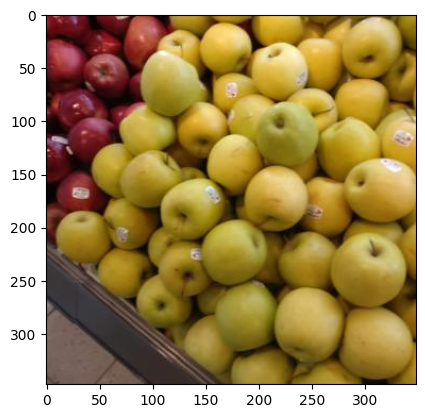

In [7]:
# Visualización de una imagen
image = load_image_data(df_images.iloc[0]["image_data"])
plt.imshow(image)
plt.show()

In [8]:
# Conversión de imágenes a matrices y visualización de sus características
I = np.array(image)
print("Image shape:", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape: (348, 348, 3)
Image range in each coordinate: [0, 255]


In [9]:
label_encoder = LabelEncoder()
df_images['encoded_labels'] = label_encoder.fit_transform(df_images['coarse_cat'])


In [10]:
# Definición de transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
# Define the Dataset class
class GroceryDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_data = self.dataframe.iloc[idx]['image_data']
        image = load_image_data(image_data)
        label = self.dataframe.iloc[idx]['encoded_labels']
        if self.transform:
            image = self.transform(image)
        return image, label


In [12]:
# Crear instancias de Dataset
train_dataset = GroceryDataset(df_images[df_images['dataset'] == 'train'], transform=transform)
val_dataset = GroceryDataset(df_images[df_images['dataset'] == 'val'], transform=transform)
test_dataset = GroceryDataset(df_images[df_images['dataset'] == 'test'], transform=transform)

In [13]:
# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
num_classes = df_images['coarse_cat'].nunique()
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.4MB/s]


In [15]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [16]:
import torch
from torch.optim import lr_scheduler
import time
import copy
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch.nn as nn
from torch import optim
from tempfile import TemporaryDirectory

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Temporal directory for saving best model parameters
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    print(inputs.shape, labels.shape)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model



In [17]:
# Entrenar y evaluar el modelo
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device=device)


Epoch 0/24
----------
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Si

In [18]:
fruits_prices = {
    "fruit_name": ["Apple", "Pear", "Satsumas", "Melon", "Orange"],
    "price": [74, 89, 44, 109, 35]
}


In [22]:
price_dict = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
    }

In [19]:
df_fruits = pd.DataFrame(fruits_prices)
df_fruits

,fruit_name,price
0,Apple,74
1,Pear,89
2,Satsumas,44
3,Melon,109
4,Orange,35


In [20]:
# Función de pérdida personalizada
def custom_loss(real_label, predicted_label, price_dict):
    real_price = price_dict[real_label]
    predicted_price = price_dict[predicted_label]
    if predicted_price > real_price:
        return ((predicted_price - real_price) * 5) # Error en perjuicio del cliente
    else:
        return (real_price - predicted_price) # Error en perjuicio del comercio

# Función para realizar predicciones y calcular la matriz de confusión
def predict_and_evaluate(model, loader, device, price_dict, label_encoder):
    model.eval()  # Modelo en modo de evaluación
    all_preds = []
    all_labels = []
    all_losses = []
    total_revenue = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for label, pred in zip(labels, preds):
                real_label = label_encoder.inverse_transform([label.item()])[0]
                predicted_label = label_encoder.inverse_transform([pred.item()])[0]
                loss = custom_loss(real_label, predicted_label, price_dict)
                all_losses.append(loss)

                if real_label == predicted_label:
                    total_revenue += price_dict[real_label]

    return all_preds, all_labels, all_losses, total_revenue



In [23]:
# Evaluar el modelo y calcular la matriz de confusión y la pérdida
predictions, labels, losses, total_revenue = predict_and_evaluate(model_ft, test_loader, device, price_dict, label_encoder)
conf_matrix = confusion_matrix(labels, predictions)
accuracy = np.mean(np.array(labels) == np.array(predictions))

# Calcular la pérdida total y la tasa de error
total_loss = sum(losses)
error_rate = total_loss / total_revenue if total_revenue != 0 else 0

In [26]:
# Mostrar los resultados
print("Matriz de Confusión:")
print(conf_matrix)
print("Real Total:")
print(total_revenue)
print("Pérdida Total:")
print(total_loss)
print("Error Rate:")
print(error_rate)
print("Accuracy Test")
print(accuracy)

Matriz de Confusión:
[[546   0   0   6   0]
 [  6 296   2   2   0]
 [  0   4  88   0  20]
 [ 42   6   2 166   0]
 [  6   0  92   0  38]]
Real Total:
92194
Pérdida Total:
6294
Error Rate:
0.06826908475605788
Accuracy Test
0.8577912254160364
